# Obtaining the magnetic field

This is an adapted version of the first example in [`1a_1D_VTI_empymod.ipynb`](https://github.com/empymod/emg3d-examples/blob/master/1a_1D_VTI_empymod.ipynb). Consult that notebook to see the result for the electric field.

The solver `emg3d` returns the electric field in x-, y-, and z-direction. Using Farady's law of induction we can obtain the magnetic field from it. Faraday's law of induction in the frequency domain can be written as, in its differential form,

$$
\nabla \times \mathbf{E} = \rm{i}\omega \mathbf{B} = \rm{i}\omega\mu\mathbf{H}\, .
$$

We do exactly this in this notebook, for a rotated finite length bipole in a homogeneous VTI fullspace, and compare it to the semi-analytical solution of `empymod`. (The code `empymod` is an open-source code which can model CSEM responses for a layered medium including VTI electrical anisotropy, see https://empymod.github.io.)

#### Requires
- ``emg3d``, ``discretize``, ``empymod``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

In [1]:
import discretize
import numpy as np
import empymod as epm
import matplotlib.pyplot as plt
from scipy import interpolate as sint
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d as e3d

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')

### Plotting and interpolation routines

In [3]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def plot_data_rel(ax, name, data, x, vmin=-15., vmax=-7., mode="log"):
    """Plot function."""
    
    ax.set_title(name)
    ax.set_xlim(min(x)/1000, max(x)/1000)
    ax.set_ylim(min(x)/1000, max(x)/1000)
    ax.axis("equal")
    
    if isinstance(mode, str):
        if mode == "abs":
            cf = ax.pcolormesh(x/1000, x/1000, np.log10(np.abs(data)), linewidth=0,
                               rasterized=True, cmap="viridis", vmin=vmin, vmax=vmax)
        else:
            cf = ax.pcolormesh(x/1000, x/1000, data, linewidth=0, rasterized=True, cmap="PuOr_r",
                               norm=SymLogNorm(linthresh=10**vmin, vmin=-10**vmax, vmax=10**vmax))
    else:
        cf = ax.pcolormesh(x/1000, x/1000, np.log10(data), vmin=vmin, vmax=vmax,
                           linewidth=0, rasterized=True, cmap=discrete_cmap(8, "RdBu_r"))

    return cf


def plot_result_rel(depm, de3d, x, title, vmin=-15., vmax=-7., mode="log"):
    fig, axs = plt.subplots(figsize=(18, 10), nrows=2, ncols=3)
    
    if mode == "log":
        case = ""
    else:
        case = "|"

    # Plot Re(data)
    cf0 = plot_data_rel(axs[0, 0], r"(a) "+case+"Re(empymod)"+case, depm.real, x, vmin, vmax, mode)
    plot_data_rel(axs[0, 1], r"(b) "+case+"Re(emg3d)"+case, de3d.real, x, vmin, vmax, mode)
    cf2 = plot_data_rel(axs[0, 2], r"(c) Error real part",
                        np.abs((depm.real-de3d.real)/depm.real)*100, x,
                        vmin=-2, vmax=2, mode=True)

    # Plot Im(data)
    plot_data_rel(axs[1, 0], r"(d) "+case+"Im(empymod)"+case, depm.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 1], r"(e) "+case+"Im(emg3d)"+case, de3d.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 2], r"(f) Error imaginary part",
                  np.abs((depm.imag-de3d.imag)/depm.imag)*100, x, vmin=-2, vmax=2, mode=True)

    # Colorbars
    fig.colorbar(cf0, ax=axs[0, :], label=r"$\log_{10}$ Amplitude (A/m)")
    cbar = fig.colorbar(cf2, ax=axs[1, :], label=r"Relative Error")
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.ax.set_yticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

    # Axis label
    fig.text(0.4, 0.05, "Inline Offset (km)", fontsize=14)
    fig.text(0.08, 0.6, "Crossline Offset (km)", rotation=90, fontsize=14)

    # Title
    fig.suptitle(title, y=1, fontsize=20)

    
def plot_lineplot_ex(x, y, data, epm_fs, grid):
    xi = x.size//2
    yi = y.size//2
    
    fn = sint.interp1d(x, data[:, xi], bounds_error=False)
    x1 = fn(grid.vectorNx)
    
    fn = sint.interp1d(y, data[yi, :], bounds_error=False)
    y1 = fn(grid.vectorNx)

    plt.figure(figsize=(15, 8))
    
    plt.plot(x/1e3, np.abs(epm_fs[:, xi]), 'C0', lw=3, label='Inline empymod')
    plt.plot(x/1e3, np.abs(data[:, xi]), 'k--', label='Inline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(x1), 'k*')
    
    plt.plot(y/1e3, np.abs(epm_fs[yi, :]), 'C1', lw=3, label='Crossline empymod')
    plt.plot(y/1e3, np.abs(data[yi, :]), 'k:', label='Crossline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(y1), 'k*', label='Grid points emg3d')

    plt.yscale('log')
    plt.title(r'Inline and crossline $H_x$', fontsize=20)
    plt.xlabel('Offset (km)', fontsize=14)
    plt.ylabel(r'|Amplitude (A/m)|', fontsize=14)
    plt.legend()
    plt.show()

## Full-space model for a finite length, finite strength, rotated bipole 

### `empymod`

In [4]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()

# Model parameters
resh = 1.              # Horizontal resistivity
aniso = np.sqrt(2.)    # Anisotropy
resv = resh*aniso**2   # Vertical resistivity
src = [-50, 50, -30, 30, -320., -280.]  # Source: [x1, x2, y1, y2, z1, z2]
src_c = np.mean(np.array(src).reshape(3, 2), 1).ravel()  # Center points of course
zrec = -400.           # Receiver depth
freq = 0.77            # Frequency
strength = np.pi       # Source strength

# Input for empymod
model = {  # empymod has positive z-down, so switch source-z
    'src': [src[0], src[1], src[2], src[3], -src[4], -src[5]],
    'depth': [],
    'res': resh,
    'aniso': aniso,
    'strength': strength,
    'srcpts': 5,
    'freqtime': freq,
    'htarg': {'pts_per_dec': -1},
}

In [5]:
epm_fs_bx = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, 0], mrec=True, verb=3, **model).reshape(np.shape(rx))
epm_fs_by = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 90, 0], mrec=True, verb=1, **model).reshape(np.shape(rx))
epm_fs_bz = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, -90], mrec=True, verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  
   res     [Ohm.m] :  1
   aniso       [-] :  1.41421
   epermH      [-] :  1
   epermV      [-] :  1
   mpermH      [-] :  1
   mpermV      [-] :  1

>  MODEL IS A FULLSPACE
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  0.77
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  123.288
     > strength[A] :  3.14159
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  300
     > azimuth [°] :  30.9638
     > dip     [°] :  -18.9318
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  400
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   : 

### `emg3d`

In [6]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = e3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = e3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20)

# Create stretched grid
nx = 2**7
hx = e3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[0])
hy = e3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[1])
hz = e3d.utils.get_stretched_h(hz_min, zdomain, nx, src_c[2])
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,408.71      4,228.19     20.00    160.52    1.03
   y    128     -4,408.71      4,228.19     20.00    160.52    1.03
   z    128     -4,388.71      4,249.67     20.00    165.56    1.03

In [7]:
# Get the model
pmodel = e3d.utils.Model(pgrid, res_x=resh, res_z=resv, freq=freq)

# Get the source field
sfield = e3d.utils.get_source_field(pgrid, src, freq, strength)

# Calculate the electric field
pfield = e3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 10:18:26 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]     error                 l2:[last/init, last/prev] l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [10:18:40] 1.867e-05 after  1 F-cycles; [2.861e-02, 2.861e-02] 0 0
   [10:18:55] 1.494e-06 after  2 F-cycles; [2.289e-03, 8.001e-02] 0 0
   [10:19:08] 1.753e-07 after  3 F-cycles; [2.686e-04

## Calculate magnetic field $H$ from the electric field

In [8]:
# Define dual grid widths.
d1 = (np.r_[0., pgrid.hx] + np.r_[pgrid.hx, 0.])/2.
d2 = (np.r_[0., pgrid.hy] + np.r_[pgrid.hy, 0.])/2.
d3 = (np.r_[0., pgrid.hz] + np.r_[pgrid.hz, 0.])/2.

# i omega mu (mu_r = 1)
iomegamu = 2j*np.pi*pmodel.freq*e3d.utils.mu_0

# Carry out the curl  and normalize

# B_x = (e3_y - e2_z)/(i omega mu)
_, HY, HZ = np.meshgrid(d1, pgrid.hy, pgrid.hz, indexing='ij')
e3d_hx = (np.diff(pfield.fz, 1, 1)/HY - np.diff(pfield.fy, 1, 2)/HZ)/iomegamu

# B_y = (e1_z-e3_x)/(i omega mu)
HX, _, HZ = np.meshgrid(pgrid.hx, d2, pgrid.hz, indexing='ij')
e3d_hy = (np.diff(pfield.fx, 1, 2)/HZ - np.diff(pfield.fz, 1, 0)/HX)/iomegamu

# B_z = (e2_x-e1_y)/(i omega mu)
HX, HY, _ = np.meshgrid(pgrid.hx, pgrid.hy, d3, indexing='ij')
e3d_hz = (np.diff(pfield.fy, 1, 0)/HX - np.diff(pfield.fx, 1, 1)/HY)/iomegamu

### Plot

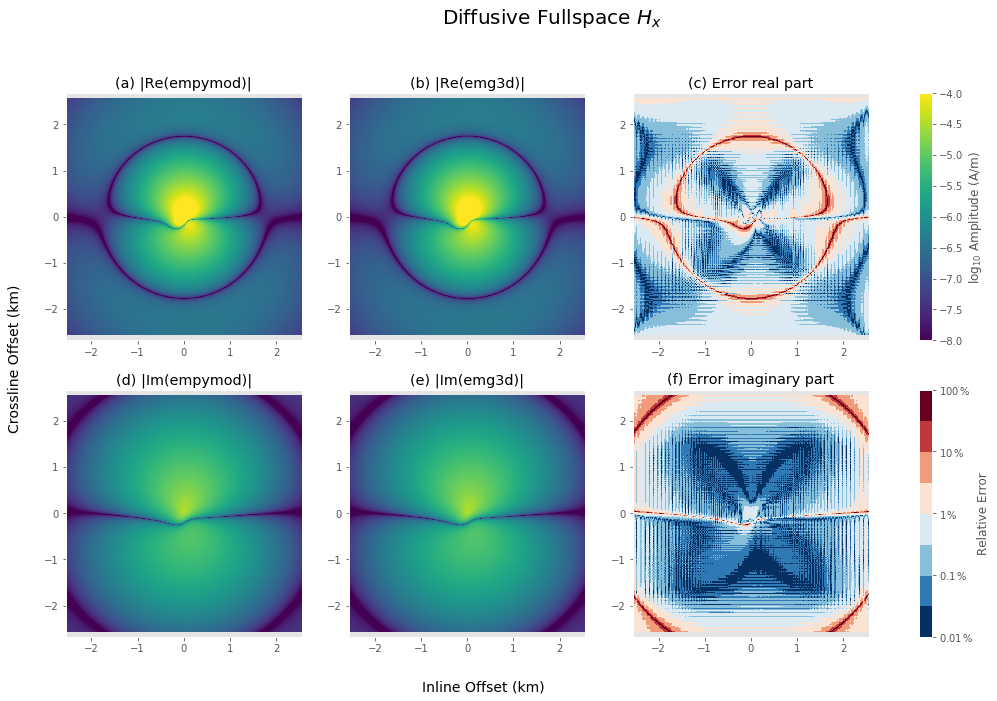

In [9]:
e3d_fs_bx = sint.interpn((pgrid.vectorNx, pgrid.vectorCCy, pgrid.vectorCCz), e3d_hx, (rx, ry, zrec))
plot_result_rel(epm_fs_bx, e3d_fs_bx, x, r'Diffusive Fullspace $H_x$', vmin=-8, vmax=-4, mode='abs')

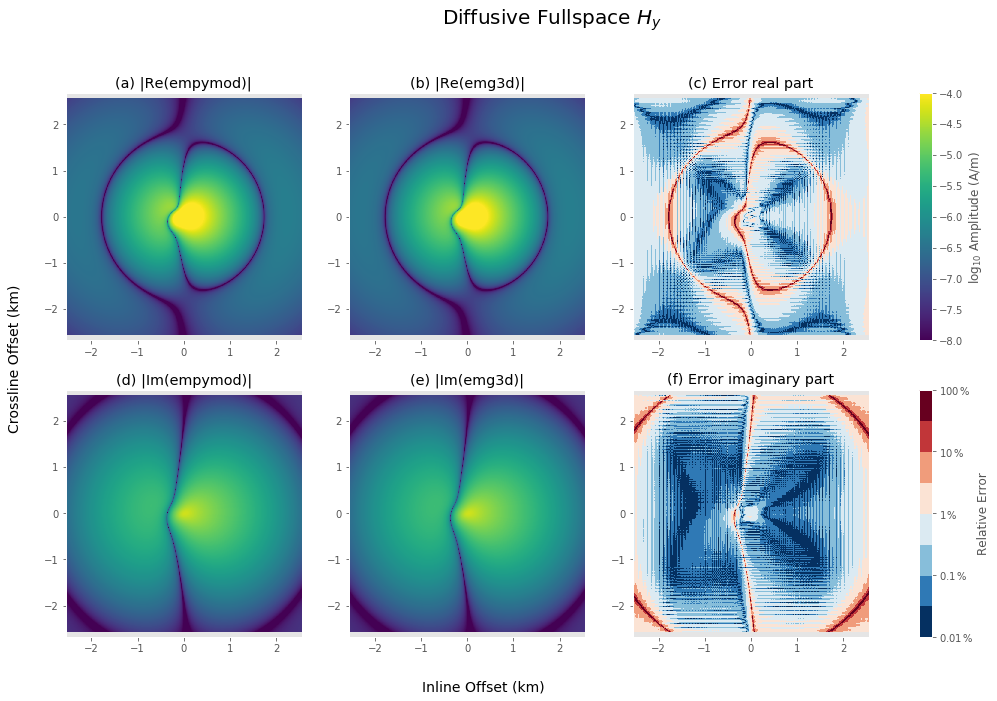

In [10]:
e3d_fs_by = sint.interpn((pgrid.vectorCCx, pgrid.vectorNy, pgrid.vectorCCz), e3d_hy, (rx, ry, zrec))
plot_result_rel(epm_fs_by, e3d_fs_by, x, r'Diffusive Fullspace $H_y$', vmin=-8, vmax=-4, mode='abs')

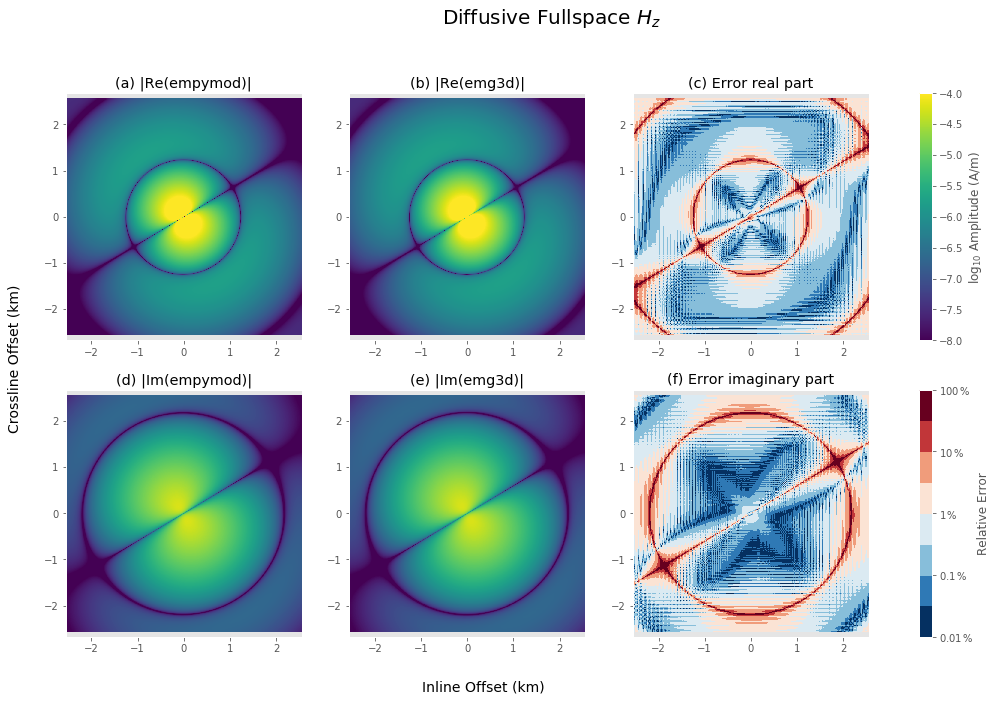

In [11]:
e3d_fs_bz = sint.interpn((pgrid.vectorCCx, pgrid.vectorCCy, pgrid.vectorNz), e3d_hz, (rx, ry, zrec))
plot_result_rel(epm_fs_bz, e3d_fs_bz, x, r'Diffusive Fullspace $H_z$', vmin=-8, vmax=-4, mode='abs')

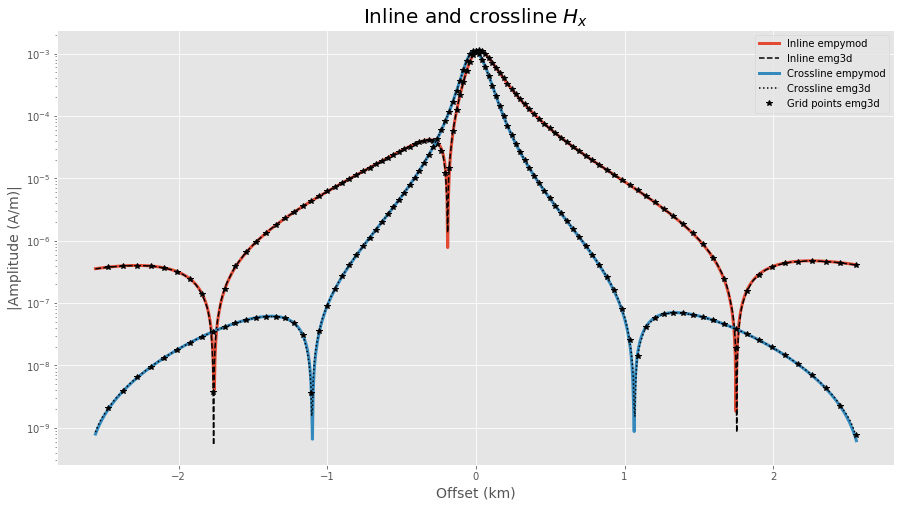

In [12]:
plot_lineplot_ex(x, x, e3d_fs_bx.real, epm_fs_bx.real, pgrid)

In [13]:
e3d.Versions(epm)

------------------------------------------------------
  Fri Jun 07 10:21:06 2019 CEST

          Linux : OS
              4 : CPU(s)
         1.16.2 : numpy
          1.2.1 : scipy
         0.43.1 : numba
          0.6.2 : emg3d
          7.4.0 : IPython
          3.0.3 : matplotlib
          1.8.2 : empymod

  3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC
  7.3.0]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------